Make a nice plot for the phoenix v g+ model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from craftroom import resample

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [4]:
#add in the phoenix spectrum
phx = Table.read('../test_files/components/hlsp_muscles_model_phx_2mass-j23062928-0502285_na_v5_component-spec.ecsv')
pw, pf = phx['WAVELENGTH'], phx['FLUX']
pscale = phx.meta['NORMFAC']
pf *= pscale

#pmask = (pw >= wo[0]) & (pw <= wo[-1])
#pwi, pfi = pw[pmask], pf[pmask]
#pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)

#pwr, pfr = smear(pwi, pfi,250)

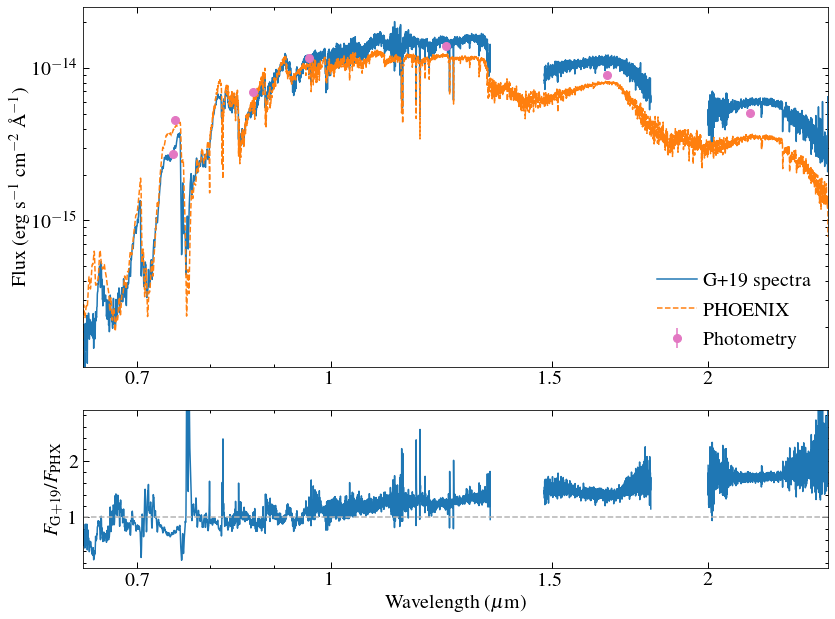

In [21]:
irpath = '/home/david/work/muscles/SEDs/trappist-1/ir_data/'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 9))
gs = GridSpec(3, 1, figure=fig)

plt.subplot(gs[:2, :])
g19data = glob.glob(irpath+'PS_Gaia*')
gw, gf, ge = np.loadtxt(g19data[0], unpack=True)
gw *=10000
gphot = np.genfromtxt(g19data[1], dtype=None, delimiter=',', names=True, encoding=None)
gpn, gpw, gpf, gpe = gphot['Band'], gphot['Wavelength'], gphot['Flux'], gphot['Error'] 
gpw*=10000
plt.plot(gw/10000, gf, label = 'G+19 spectra')
plt.errorbar(gpw/10000, gpf, yerr=gpe, marker='o', ls='none', label = 'Photometry', zorder=10, markersize=8, c='C6')


pmask = (pw >= gw[0]) & (pw <= 8000)
pwi, pfi = pw[pmask], pf[pmask]
#pwi, pfi = resample.bintogrid(pwi, pfi, newx = gw)
pw1, pf1 = smear(pwi, pfi,1200)
pmask = (pw >= 8000) & (pw <= gw[-1])
pwi, pfi = pw[pmask], pf[pmask]
#pwi, pfi = resample.bintogrid(pwi, pfi, newx = gw)
pw2, pf2 = smear(pwi, pfi,6000)

pwp, pfp = np.hstack((pw1, pw2)), np.hstack((pf1, pf2))

plt.plot(pwp/10000, pfp, label='PHOENIX', c='C1', ls='--')

plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
plt.xscale('log')
plt.yscale('log')
plt.xticks((0.7, 1, 1.5, 2), ('0.7', '1', '1.5', '2'))
plt.legend(loc=4)
plt.ylim(1.1e-16, 2.5e-14)


plt.subplot(gs[2, :])
pwi, pfi = resample.bintogrid(pwp, pfp, newx = gw)
plt.plot(gw/10000, gf/pfi)
plt.axhline(1.0, ls='--', c='0.7')
plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.ylabel('$F_{\mathrm{G+19}}$/$F_{\mathrm{PHX}}$', size=20)
plt.xlabel('Wavelength ($\mu$m)', size=20)
plt.xscale('log')
plt.xticks((0.7, 1, 1.5, 2), ('0.7', '1', '1.5', '2'))
plt.tight_layout()
plt.ylim(0.1, 2.9)
plt.savefig('../plots/t1_phoenix_compare.pdf')


Test- where is a good cutoff for the Phoenix model?

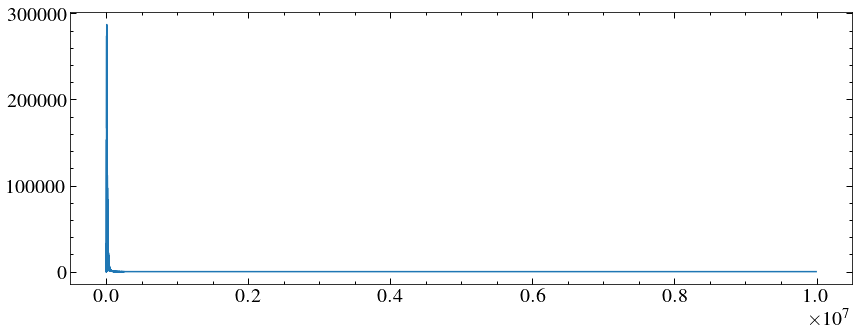

In [6]:
sp = 'lyon_phoenix/lte026.0-5.0-0.0a+0.0.BT-Settl.spec.7'
DF = -8
#params = {'Teff':ts[i], 'logg':gs[i], 'FeH':0.0, 'aM':0.0}
phoenixR = ascii.read(sp,format="fixed_width_no_header",col_starts=(0,14),col_ends=(12,25),delimiter=" ",names=('Wave','Spec'))
#print(len(phoenixR['Wave']))
ph1, jj = np.unique(np.array(phoenixR['Wave']),return_index=True)
phoenix = np.zeros((len(ph1),2))
for kk in range(len(jj)):
    phoenix[kk,1] = np.float64(phoenixR['Spec'][jj[kk]].replace("D","E"))
phoenix[:,0] = ph1
#ind = np.where( (phoenix[:,0] <= wavemax) & (phoenix[:,0] >= wavemin))[0]  
xraw = phoenix[:,0]
yraw = np.power(10.,phoenix[:,1] + DF)#.tolist()
#waves.append(xraw)
#fluxes.append(yraw)
plt.plot(xraw, yraw)

In [22]:
#all_int = np.trapz(yraw, xraw)
#cuts = np.arange(xraw[-1], xraw[0], -1000)
#cut_ints = []
#for cut in cuts:
 #   mask = (xraw < cut)
  #  cut_ints.append(np.trapz(yraw[mask], xraw[mask]))
#plt.plot(cuts, cut_ints/all_int)

KeyboardInterrupt: 

In [ ]:
#ratios = np.array(cut_ints)/all_int
#plt.plot(cuts, ratios)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0, 100000)
#plt.axhline(0.99)
#print(cuts[np.where(ratios > 0.99)][-1])
#plt.axvline(cuts[np.where(ratios > 0.99)][-1])

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    0.5464730556199651 0.5844910500019187


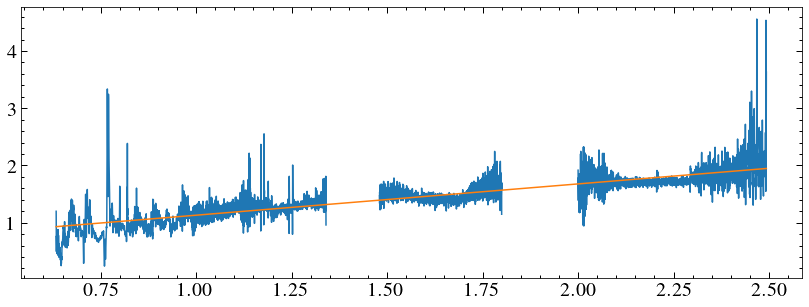

In [38]:
x, y = gw/10000, gf/pfi 
plt.plot(x,y)
fitter = fitting.LinearLSQFitter()
# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line = fitter(line_init, x[y<3], y[y<3])
plt.plot(x, fitted_line(x))
print(fitted_line)

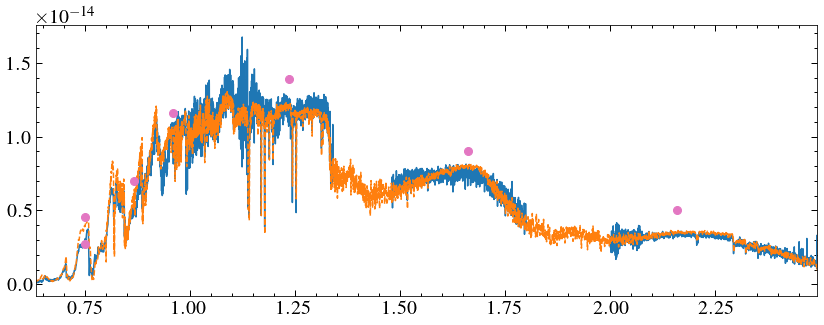

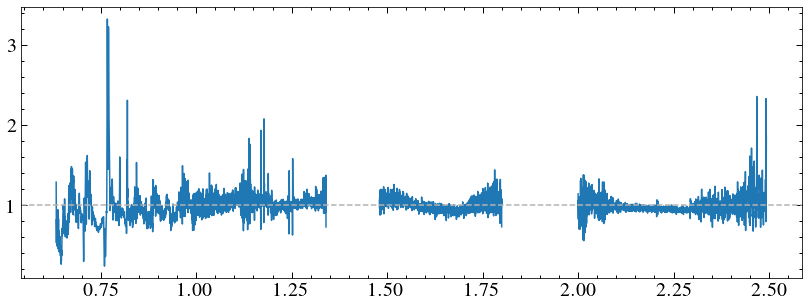

In [60]:
scale = fitted_line(pwp/10000)
#plt.plot(pwp/10000, pfp*scale, label='PHOENIX', c='C1', ls='--')
plt.plot(gw/10000, gf/fitted_line(x), label = 'G+19 spectra')
plt.plot(pwp/10000, pfp, label='PHOENIX', c='C1', ls='--')
plt.errorbar(gpw/10000, gpf, yerr=gpe, marker='o', ls='none', label = 'Photometry', zorder=10, markersize=8, c='C6')
plt.xlim(gw[0]/10000, gw[-1]/10000)
#plt.xlim(1.5, 1.55)
#plt.savefig('linfit_model.png')
plt.show()

plt.plot(gw/10000, gf/pfi/fitted_line(x))
plt.axhline(1.0, ls='--', c='0.7')

plt.show()

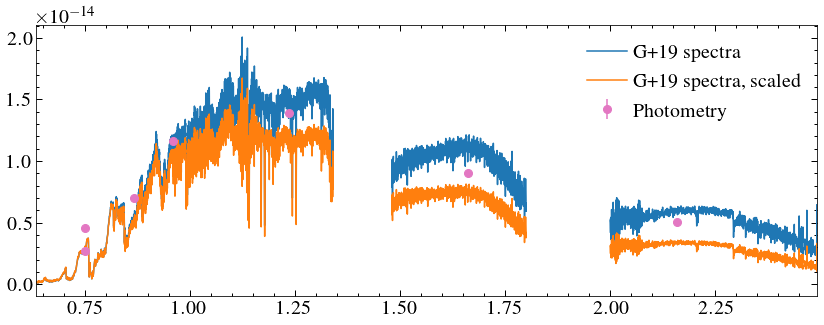

In [63]:
plt.plot(gw/10000, gf, label = 'G+19 spectra')
plt.plot(gw/10000, gf/fitted_line(x), label = 'G+19 spectra, scaled')
plt.errorbar(gpw/10000, gpf, yerr=gpe, marker='o', ls='none', label = 'Photometry', zorder=10, markersize=8, c='C6')
plt.xlim(gw[0]/10000, gw[-1]/10000)
plt.legend()